In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.layers import Add


2025-08-01 10:38:59.178634: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-01 10:38:59.335938: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-01 10:38:59.336029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-01 10:38:59.360533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 10:38:59.411921: I tensorflow/core/platform/cpu_feature_guar

In [2]:
MODEL_NAME = 'vgg16'  # 'vgg16' or 'resnet50'
INPUT_SHAPE = (224, 224, 3)
NUM_SAMPLES = 100
TARGET_POSITION = (14, 14)  # (h, w) center of last feature map
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
def get_model_and_layer(model_name):
    if model_name == 'vgg16':
        model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
        target_layer = model.get_layer('block5_conv3')
        preprocess = preprocess_vgg
    elif model_name == 'resnet50':
        model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
        target_layer = model.get_layer('conv5_block3_out')
        preprocess = preprocess_resnet
    else:
        raise ValueError("Unsupported model")

    # Create a model that outputs the target layer
    submodel = tf.keras.Model(inputs=model.input, outputs=target_layer.output)
    return submodel, preprocess



def remove_maxpool_layers(model):
    """
    Takes a trained TF/Keras model and returns a new model with all MaxPooling layers removed.
    Preserves Conv2D weights (3x3).
    """
    # Create a new Sequential model
    new_model = tf.keras.Sequential()
    
    for layer in model.layers:
        # Skip MaxPooling layers
        if 'MaxPooling' in layer.__class__.__name__:
            continue
        
        # If Conv2D, copy the layer with weights
        if isinstance(layer, tf.keras.layers.Conv2D):
            # Create a new Conv2D layer with same config
            config = layer.get_config()
            new_layer = tf.keras.layers.Conv2D(
                filters=config['filters'],
                kernel_size=config['kernel_size'],
                strides=config['strides'],
                padding=config['padding'],
                activation=config['activation'],
                use_bias=config['use_bias'],
                kernel_initializer=tf.keras.initializers.Constant(layer.get_weights()[0]),
                bias_initializer=tf.keras.initializers.Constant(layer.get_weights()[1]) if layer.use_bias else None
            )
            new_model.add(new_layer)
        
        else:
            # Add any other non-pooling layers (ReLU, BatchNorm, Flatten, Dense, etc.)
            new_model.add(layer.__class__.from_config(layer.get_config()))
            # Set weights if layer has any
            if layer.get_weights():
                new_model.layers[-1].set_weights(layer.get_weights())
    
    return new_model

model, preprocess_fn = get_model_and_layer(MODEL_NAME)

model = remove_maxpool_layers(model)

2025-08-01 10:39:00.998177: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-01 10:39:01.166841: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-01 10:39:01.168340: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 128)     147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 256)     295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 256)     590080    
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 256)     5

In [5]:
model.output.shape[1:3]

TensorShape([224, 224])

In [6]:
def compute_erf(model, preprocess_fn, num_samples=10, target_pos=(14,14)):
	grads_accum = np.zeros(INPUT_SHAPE[:2], dtype=np.float32)

	for i in range(num_samples):
		img = np.random.uniform(low=0, high=255, size=(1, *INPUT_SHAPE)).astype(np.int32)
		img_pp = preprocess_fn(img.copy())
		img_pp = tf.convert_to_tensor(img_pp)
		with tf.GradientTape() as tape:
			tape.watch(img_pp)
			feature_maps = model(img_pp, training=False)
			print(f"Feature maps shape: {feature_maps.shape}")
			y = feature_maps[0, target_pos[0],  target_pos[1], 12]

			#scalar = tf.reduce_sum(y)
			#print(scalar)

		grads = tape.gradient(y, img_pp)[0]
		squared_grad = tf.square(grads)
		grads_accum += tf.reduce_sum(squared_grad, axis=-1).numpy()

	erf = grads_accum / num_samples
	#erf = tf.nn.relu(erf)
	return erf

erf_map = compute_erf(model, preprocess_fn, NUM_SAMPLES, np.array(model.output.shape[1:3].as_list())//2)


2025-08-01 10:39:02.314346: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-08-01 10:39:02.372029: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-08-01 10:39:02.373519: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 12.0
2025-08-01 10:39:02.373527: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-08-01 10:39:02.373563: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-08-01 10:3

Feature maps shape: (1, 224, 224, 512)


2025-08-01 10:39:25.572999: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-08-01 10:39:25.574791: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 224, 224, 512)
Feature maps shape: (1, 2

KeyboardInterrupt: 

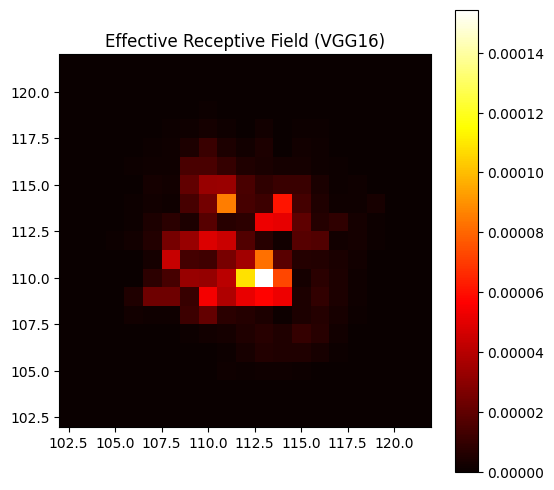

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(erf_map, cmap='hot')

S = 10
x_min, x_max = INPUT_SHAPE[0]//2 - S , INPUT_SHAPE[1]//2 + S
y_min, y_max =INPUT_SHAPE[0]//2 - S , INPUT_SHAPE[1]//2 + S

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.colorbar()
plt.title(f'Effective Receptive Field ({MODEL_NAME.upper()})')
plt.show()